# Supervised Learning: SVM

In [1]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython.display import display

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Overview

SVM 도 다른 알고리즘들처럼 Classifier `SVC`, Regressor `SVR` 가 존재합니다. 하지만, DT 처럼 이 책에서는 Classifier 만 다룹니다.

잠깐, [Linear Models](02-linear-models.ipynb) 편에서 이미 `LinearSVC`가 `make_forge()`, `cancer`에 대해서 잘 동작한다고 확인하지 않았나요?

네, 그래서 이번 장에서는 

1. `make_blobs(center=4)`로 non-linear 하게 만들어서 SVM이 왜 좋은지 보고
2. `make_forge()`로 decision boundary 설정을 알아보고
3. `cancer`로 prediction score 를 높히도록 하겠습니다.

## Dataset: make_blobs(center=4)

Linear models 로 잘 안되는 데이터셋을 SVM으로 돌려봅니다.

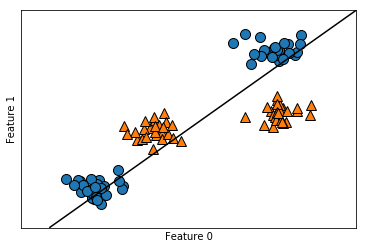

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y %= 2

from sklearn.svm import LinearSVC 
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

그림만 봐도 잘 안되죠? 

여기에 SVM의 트릭이 들어갑니다. `(feature0, feature1)`이던것을 `(feature0, feature1, feature1 ** 2)`으로 해볼까요?

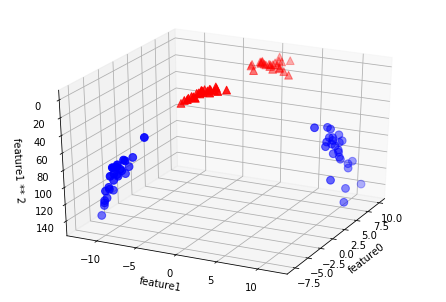

In [4]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)

# plot first all the points with y == 0, then all with y == 1
mask = (y == 0)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2");

이제는 3차원으로 보니 뭔가 나눠질 거 같죠? 여기에 `LinearSVC` 를 적용합니다.

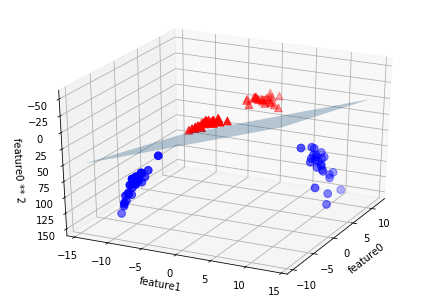

In [5]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature0 ** 2");

Feature space 를 조작하니 나중에는 Linear 로 잘 되네요? 책에서는 이렇게 정리합니다.

    The lesson here is that adding nonlinear features to the representation of our data can make linear models much more powerful. 
    
그런데 이걸 어케 하냐? `Kernel Tricks`라고 알아서 해준답니다. 두 가지 방법이 있다네요.

1. **The polynomial kernel**, which computes all possible polynomials up to a certain degree of the original features (like feature1 ** 2 * feature2 ** 5)
2. **The radial basis function (RBF) kernel**, also known as the Gaussian kernel. The Gaussian kernel is a bit harder to explain, as it corresponds to an infinite-dimensional feature space. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but the importance of the features decreases for higher degrees.

## Dataset: make_forge()

SVM은 boundary 에 있는 데이터들에 대해서 선을 그어주는걸로 모델을 만들어 나가는데요. 그 boundary 에 있는 data point들을 **support vector**라고 한다네요. SVM 이름이 거기서 나왔다구요.

우리는 특히 RBF (Gaussian) kernel 에 대해서 알아볼껀데요. 거기서 data point distance 는 이렇게 정의된답니다.

$$
k_{rbf}(x_1, x_2) = \exp(\gamma \left\|x_1 - x_2 \right\|^2)
$$

우선 support vector 를 한번 보시죠.

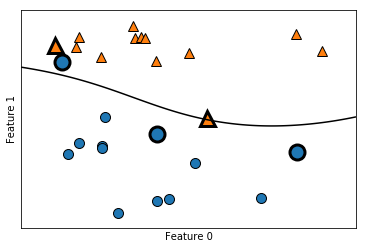

In [6]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

여기서, 우리는 두가지 변수에 대해서 튜닝을 할 수 있습니다.
- **gamma**: 위에서 나온 distance 관련 파라메터입니다. 
    
    A small gamma means a large radius for the Gaussian kernel, which means that many points are considered close by. This is reflected in very smooth decision boundaries on the left, and boundaries that focus more on single points further to the right. A low value of gamma means that the decision boundary will vary slowly, which yields a model of low complexity, while a high value of gamma yields a more complex model.
    
- **C**: 앞에서도 나왔던 regularization 파라메터입니다.

    A small C means a very restricted model, where each data point can only have very limited influence.

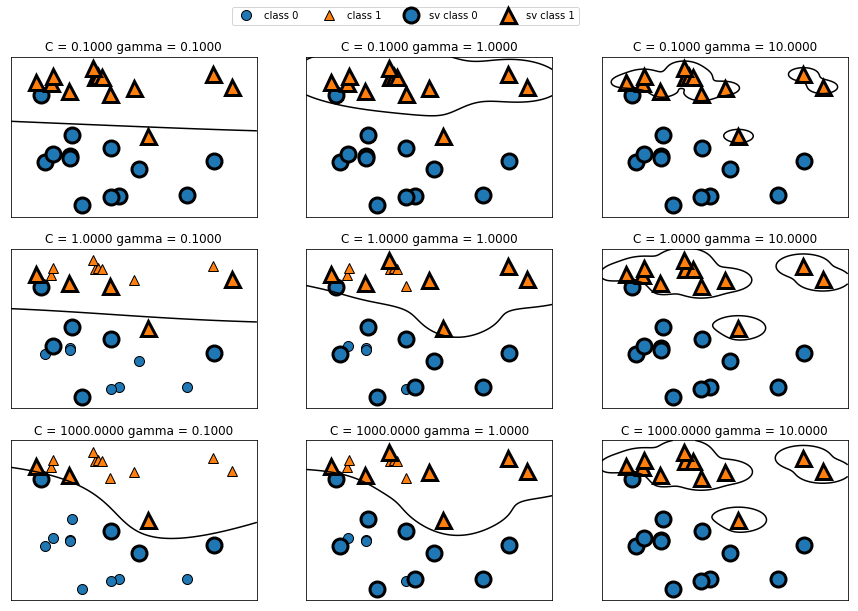

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2));

## Dataset: Cancer

이제 Cancer dataset으로 `gamma`와 `C`의 상관관계를 더 살펴보죠. 기본값을 이렇게 된답니다.

- $c = 1$
- $\gamma = \frac{1}{n\_features}$

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cancer = sklearn.datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


너무 overfitting 되어있죠. feature 들이 어떤 범위로 있는지 좀 볼까요?

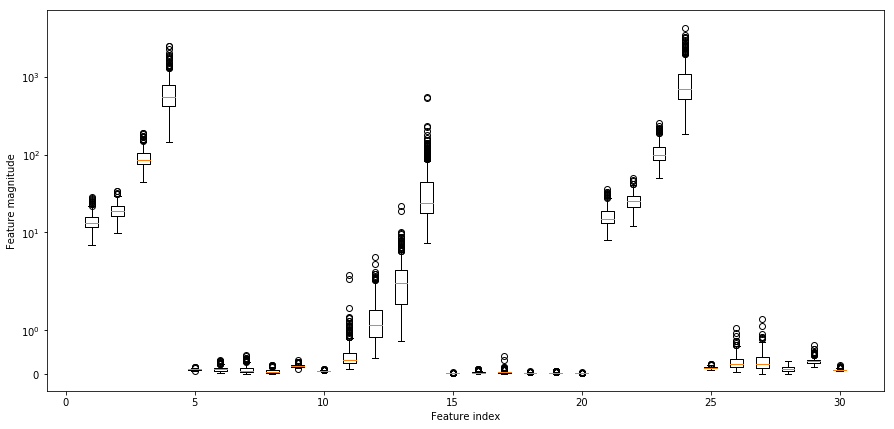

In [20]:
plt.figure(figsize=(15, 7))
plt.boxplot(X_train, manage_xticks=False)
plt.yscale('symlog')
plt.xlabel('Feature index')
plt.ylabel('Feature magnitude');

Feature 의 단위가 너무 다르기에 `MinMaxScaler()`를 사용해서 값들을 비슷한 범위에 있도록 조정하겠습니다.

In [11]:
# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [12]:
# use THE SAME transformation on the test set,
# using min and range of the training set (see Chapter 3 for details)
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


In [13]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


## 장단점

- 장점
    - 일반적으로 잘된다
    - complex decision boundary 를 만들 수 있다.
    - low / high dimension 다 잘된다 (up to 10k samples 까지)
- 단점
    - scale 안한다 (100k+ sample 이면 runtime/memory 다 어려워진다)
    - Data Preprocessing 이 많이 필요하다 (cancer 예제)
    - 튜닝 필요: `gamma`, `C`